# Snowpack model </a><a name='top'>

This notebook is an example of how to use the developed model (layer detection and compaction model from lidar time-lapse data) on a typical dataset.

Parameters are defined in the file **parameter.py**, to be adjusted before launching the notebook, but additional information must be filled in in [**this section**](#fill-in). Once these two sections are filled-in, the whole notebook may be run.

## Imports and functions

In [1]:
%run little_awk_functions.py
%run parameters.py

In get_met_forcing() - Warning: check the format of your file corresponds to the indices given in the functions (wind speed 5, surface temperature 8, time 0).


## Define needed information to run the whole notebook </a><a name='fill-in'>

In [2]:
dataset_file_name = 'snow_pit_1_filled.nc'

# Snow layers figure

nb_layers_to_plot = 15
figure_size = (16, 8)
save_fig_file = False
fig_file_name = 'snow_layers.png'

[Back to top section](#top)

## Define dataset and clean data

In [3]:
# Pre-processing to get clean data

data_set_used = xr.open_dataset(dataset_file_name)

data_set_used = data_set_used.ffill(dim='time')

median_space_filtering(data_set_used, 5, x_span=9, y_span=9)
median_time_filtering(data_set_used, 11)

# Redefine the zero of the dataset

data_set_used['snow_surface'] = data_set_used['snow_surface'] - data_set_used['snow_surface'].isel(x=x_sel, y=y_sel).dropna('time').min()


---> Median filtering in space with a window [9, 9]
---> Median filtering in time with a window of 11


## Get timing values

In [4]:
# Define dates

data_starting_date_in_ns = float(data_set_used.time.values[0])

# Define the number of iterations based on duration of the data

data_starting_date_in_s = pd.to_datetime(data_set_used.time.values[0]).timestamp()
data_ending_date_in_s = pd.to_datetime(data_set_used.time.values[-1]).timestamp()
data_duration_in_s = data_ending_date_in_s - data_starting_date_in_s
nb_iterations = int(data_duration_in_s/dt + 1)

In [5]:
# Get timing of events

results = get_snow_events(data_set_used, x_sel, y_sel, time_window_std, std_threshold)
start_accumulation, start_erosion, end_accumulation, end_erosion = results[0], results[1], results[2], results[3]

# Convert end times into more manageable orders of magnitude

end_accumulation_times = data_set_used.snow_surface.isel(x=x_sel, y=y_sel, time=end_accumulation)
end_accumulation_times = (pd.to_datetime(end_accumulation_times.time).astype(int) - data_starting_date_in_ns) / 1000000000  # in s

end_erosion_times = data_set_used.snow_surface.isel(x=x_sel, y=y_sel, time=end_erosion)
end_erosion_times = (pd.to_datetime(end_erosion_times.time).astype(int) - data_starting_date_in_ns) / 1000000000  # in s

# In case of ice detection, also convert start times to more manageable orders of magnitude

if simul_detect_ice:
    
    start_accumulation_times = data_set_used.snow_surface.isel(x=x_sel, y=y_sel, time=start_accumulation)
    start_accumulation_times = (pd.to_datetime(start_accumulation_times.time).astype(int) - data_starting_date_in_ns) / 1000000000  # in s

    start_erosion_times = data_set_used.snow_surface.isel(x=x_sel, y=y_sel, time=start_erosion)
    start_erosion_times = (pd.to_datetime(start_erosion_times.time).astype(int) - data_starting_date_in_ns) / 1000000000  # in s
    
else:
    
    start_accumulation_times = None
    start_erosion_times = None

## Simulate evolution of snowpack

In [6]:
# Simulate the snowpack

snowpack = simulate_snowpack_evolution(data_set_used, x_sel, y_sel, nb_iterations, end_accumulation_times, end_erosion_times,
                                       start_accumulation, end_accumulation, start_erosion, end_erosion, jj, dt, ro_layer, ro_water, ro_ice,
                                       t_old, tf, tsfc, dy_snow, age_layers, gamma, cp_snow, melt_flag, a1, a2, met_temp_data=met_temp, met_wind_data=met_wind,
                                       met_time_data=met_time, fit_top_of_snowfall_to_curve=simul_fit_top_of_snowfall_to_curve, erode_several_layers=simul_erode_several_layers,
                                       detect_ice=simul_detect_ice, start_accumulation_times=start_accumulation_times, start_erosion_times=start_erosion_times,
                                       a1_vector=simul_a1_vector, slope_threshold=simul_slope_threshold, min_duration_in_s=simul_min_duration_in_s)

ro_layer_evolution, depth_evolution, temperature_evolution, ice_layers_timing = snowpack[0], snowpack[1], snowpack[2], snowpack[3]


## Plot results

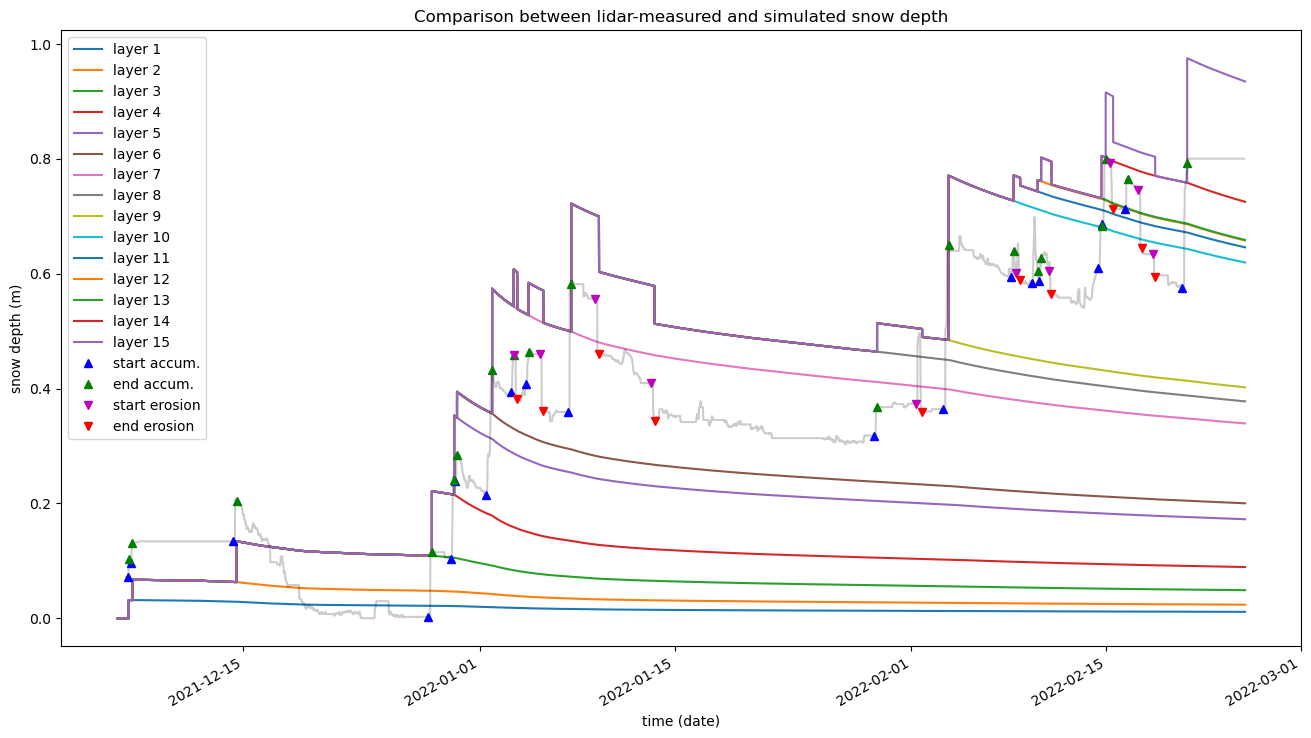

()

In [7]:
plot_simul_and_signal(data_set_used, x_sel, y_sel, depth_evolution, nb_layers_to_plot, pd.to_datetime(data_set_used.time.values[0]), dt, nb_iterations,
                      start_accumulation, end_accumulation, start_erosion, end_erosion, ice_layers_times=ice_layers_timing, my_figsize=figure_size, save_file=save_fig_file, my_file_name=fig_file_name)